# Machine Learning on Cell: KMeans

In [66]:
from sklearn.cluster import KMeans

import pandas as pd

import pandas.io.sql as sqlio

import psycopg2

import matplotlib.pyplot as plt

In [88]:
n_clusters = 5
zoom = 6

In [89]:
conn = psycopg2.connect("dbname=cell user=cell_master password=38fn3k39erj34n8 host=kepler port=5632")
sql = "select * from ml.pop_structure_%s" % zoom

In [90]:
data = sqlio.read_sql_query(sql, conn)
data.columns = ["z", "x", "y", "p18", "p1864", "p64"]
data.head()

,z,x,y,p18,p1864,p64
0,6,312,983,0.21,0.68,0.11
1,6,312,988,0.12,0.68,0.20
2,6,312,989,0.10,0.73,0.17
3,6,312,990,0.15,0.76,0.09
4,6,312,1008,0.23,0.50,0.27


In [91]:
data.describe()

,z,x,y,p18,p1864,p64
count,22192.0,22192.000000,22192.000000,22192.000000,22192.000000,22192.000000
mean,6.0,1247.592466,760.533075,0.165861,0.666990,0.167285
std,0.0,469.120867,230.434894,0.078536,0.099513,0.113228
min,6.0,312.000000,329.000000,0.000000,0.000000,0.000000
25%,6.0,832.000000,550.000000,0.120000,0.620000,0.090000
50%,6.0,1244.500000,716.000000,0.160000,0.660000,0.160000
75%,6.0,1621.250000,959.000000,0.210000,0.710000,0.230000
max,6.0,2338.000000,1414.000000,0.580000,1.000000,1.000000


In [92]:
kmeans = KMeans(n_clusters=n_clusters).fit(data[["p18", "p1864", "p64"]])
kmeans.predict(data[["p18", "p1864", "p64"]])

array([1, 1, 1, ..., 0, 1, 0], dtype=int32)

In [93]:
data["cluster"] = kmeans.predict(data[["p18", "p1864", "p64"]])
data[["cluster", "p18", "p1864", "p64", "cluster"]].head()

,cluster,p18,p1864,p64,cluster
0,1,0.21,0.68,0.11,1
1,1,0.12,0.68,0.20,1
2,1,0.10,0.73,0.17,1
3,1,0.15,0.76,0.09,1
4,0,0.23,0.50,0.27,0


In [94]:
data[[ "cluster", "p18", "p1864", "p64" ]].groupby(["cluster"]).agg([ "count", "mean" ])

p18           p1864             p64          
        count      mean count      mean count      mean
cluster                                                
0        7112  0.134128  7112  0.608098  7112  0.257988
1        9132  0.161496  9132  0.698753  9132  0.139895
2        4468  0.274593  4468  0.667939  4468  0.057498
3         846  0.004007   846  0.994243   846  0.001749
4         634  0.034401   634  0.426767   634  0.538912

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7aa12ac340>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7aa12aca60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7aa129af70>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7aa12b81c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7aa12b8550>,
 'means': []}

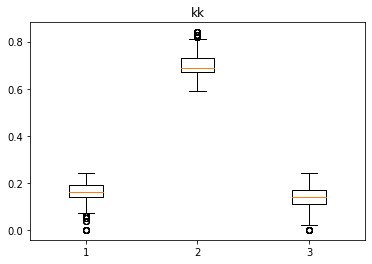

In [95]:
fig1, ax1 = plt.subplots()
ax1.set_title("kk")
ax1.boxplot(data[data.cluster == 1][["p18", "p1864", "p64" ]])

In [96]:
cur = conn.cursor()
sql = ""

for i, r in data.iterrows():
    sql = sql + 'update cell_data.data set data = data || \'{ "8932": %i }\'::jsonb where zoom=%i and x=%i and y=%i;' % (r["cluster"], r["z"], r["x"], r["y"])

In [97]:
cur.execute(sql)
conn.commit()
cur.close()
conn.close()